# Library

In [1]:
import os
import random
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy

# Audio Library
import librosa
import librosa.util
from IPython.display import Audio

# Preprocessing data
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

# Model
import optuna
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns

# Functions

## Preprocess

In [12]:
#load data
def center_crop(y, target_len):
    current_len = len(y)
    if current_len <= target_len:
        pad_len = target_len - current_len
        left = pad_len // 2
        right = pad_len - left
        return np.pad(y, (left, right))
    else:
        start = (current_len - target_len) // 2
        end = start + target_len
        return y[start:end]

def load_audio(file_path, duration=3):
    y, sr = librosa.load(file_path)
    target_len = sr * duration
    y = center_crop(y, target_len)
    y = librosa.util.normalize(y)
    return y, sr

In [13]:
#test audio
def test_audio(df, index):
    display(df[['emotion']].iloc[index])
    return Audio(data=df['audio'].iloc[index], rate=22050)

In [14]:
#oversampling + pitch shift
def pitch_shift_audio(y, sr=22050, max_steps=2):
    steps = random.randint(-max_steps, max_steps)
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=steps)

In [15]:
#add noise
def add_noise(y, min_level=0.005, max_level=0.007):
    noise_level = np.random.uniform(min_level, max_level)
    noise = np.random.randn(len(y))
    augmented = y + noise_level * noise
    return augmented / np.max(np.abs(augmented))

## Feature extraction

In [16]:
def pad_or_truncate(feat, max_len):
    T = feat.shape[1]
    if T < max_len:
        return np.pad(feat, ((0, 0), (0, max_len - T)), mode='constant')
    else:
        return feat[:, :max_len]

def standardize_clip(feat):
    return normalize(feat, norm='l2', axis=0)

In [17]:
def extract_features_stacked(y, sr=22050, max_len=130):
    features = []

    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc = pad_or_truncate(mfcc, max_len)
    mfcc = standardize_clip(mfcc)
    features.append(mfcc)

    # Mel
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db = pad_or_truncate(mel_db, max_len)
    mel_db = standardize_clip(mel_db)
    features.append(mel_db)

    # Stack and reshape
    features = np.stack(features, axis=0)  # shape: (2, 40, T)
    features = features.transpose(0, 2, 1)  # shape: (2, T, 40)
    return features

# Loading data

In [18]:
#Load folder
root_path = "RAVDESS"
Ravdess_paths = sorted(os.listdir(root_path))

In [19]:
#Setup dataframe
ravdess_db = pd.DataFrame(columns=['path','actor', 'gender', 'emotion'])
count = 0

emotion_map = {
    1: "neutral", 2: "calm", 3: "happy",
    4: "sad", 5: "angry", 6: "fearful",
    7: "disgust", 8: "surprised"
}

for actor_folder in Ravdess_paths:
    actor_path = os.path.join(root_path, actor_folder)
    if not os.path.isdir(actor_path):
        continue

    file_list = os.listdir(actor_path)
    for f in file_list:
        name_parts  = f.split('.')[0].split('-')
        full_path = os.path.join(actor_path, f)
        src = int(name_parts[1])
        actor = int(name_parts[-1])
        emotion = int(name_parts[2])
        gender = 1 if actor % 2 == 0 else 0

        ravdess_db.loc[count] = [full_path, actor, gender, emotion]
        count += 1

print (len(ravdess_db))
df = ravdess_db
df['path'] = df['path'].str.replace('\\', '/', regex=False)

1440


In [20]:
#Load audio files
df['audio'] = df['path'].apply(load_audio)
df['audio1'] = df['audio'].apply(lambda x: x[0])
df['sr'] = df['audio'].apply(lambda x: x[1])

df = df.drop(['audio'],axis=1)
df.columns = ['path', 'actor', 'gender', 'emotion',	'audio', 'sr']

df.head()

,path,actor,gender,emotion,audio,sr
0,RAVDESS/Actor_01/03-01-01-01-01-01-01.wav,1,0,1,"[2.3772009e-05, -5.7711495e-06, -7.6655056e-07...",22050
1,RAVDESS/Actor_01/03-01-01-01-01-02-01.wav,1,0,1,"[-6.009213e-06, 6.20998e-06, -6.8420186e-06, 7...",22050
2,RAVDESS/Actor_01/03-01-01-01-02-01-01.wav,1,0,1,"[-8.8255365e-07, 1.8787647e-07, 5.2544624e-07,...",22050
3,RAVDESS/Actor_01/03-01-01-01-02-02-01.wav,1,0,1,"[-0.0002699747, -9.23348e-05, 2.5009613e-05, -...",22050
4,RAVDESS/Actor_01/03-01-02-01-01-01-01.wav,1,0,2,"[-4.209445e-07, 1.7298688e-06, -3.2236057e-06,...",22050


1: "neutral", 2: "calm", 3: "happy",

4: "sad", 5: "angry", 6: "fearful",

7: "disgust", 8: "surprised"

# Data Preparation

## Oversampling

In [21]:
#check balance
df['emotion'].value_counts()

emotion
2    192
3    192
4    192
5    192
7    192
6    192
8    192
1     96
Name: count, dtype: int64

In [22]:
#oversampling + pitch shift
df_copy = df.copy()
neutral_df = df_copy[df_copy['emotion'] == 1]
other_df = df_copy[df_copy['emotion'] != 1]

target_samples = 192
n_to_add = max(0, target_samples - len(neutral_df))

augmented = []
for _ in range(n_to_add):
    sample = neutral_df.sample(1, replace=True).iloc[0]
    y = sample['audio']
    sr = sample['sr']
    y_aug = pitch_shift_audio(y, sr)
    y_aug = np.array(y_aug, dtype=np.float32)

    new_sample = sample.copy()
    new_sample['audio'] = y_aug
    augmented.append(new_sample)

aug_df = pd.DataFrame(augmented)
aug_df['audio'] = aug_df['audio'].apply(lambda x: np.array(x) if isinstance(x, pd.Series) else x)
df_balanced = pd.concat([other_df, neutral_df, aug_df]).sample(frac=1, random_state=42).reset_index(drop=True)

In [23]:
#check balance
df_balanced['emotion'].value_counts()

emotion
6    192
4    192
1    192
5    192
3    192
2    192
8    192
7    192
Name: count, dtype: int64

## Add noise

In [24]:
#Add noise
noisy_samples = []
for idx, row in df_balanced.iterrows():
    y = row['audio']
    sr = row['sr']
    y_noisy = add_noise(y)
    
    new_row = row.copy()
    new_row['audio'] = y_noisy
    noisy_samples.append(new_row)

df_noise = pd.DataFrame(noisy_samples)
df_final = pd.concat([df_balanced, df_noise], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
df_final = df_final.iloc[:,1:]
df_final = df_final[['emotion', 'audio']]

In [25]:
display(df_final.head())
print('Shape:',df_final.shape)

,emotion,audio
0,8,"[-0.012822569931418486, 0.009035686581483097, ..."
1,6,"[0.0008620186596705079, -0.0035831800170917547..."
2,3,"[-0.003979578978156553, -0.00469015487090776, ..."
3,5,"[0.00050837494, 0.00026778216, 0.0002876023, 0..."
4,7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Shape: (3072, 2)


# Feature extraction

In [26]:
df_final['features'] = df_final['audio'].apply(lambda y: extract_features_stacked(y))
X = np.stack(df_final['features'].values, axis=0)  # shape: (N, 2, T, 40)
y = df_final['emotion'].values - 1

In [27]:
print(X.shape, y.shape)
df_final['emotion'].value_counts()

(3072, 2, 130, 40) (3072,)


emotion
8    384
6    384
3    384
5    384
7    384
4    384
1    384
2    384
Name: count, dtype: int64

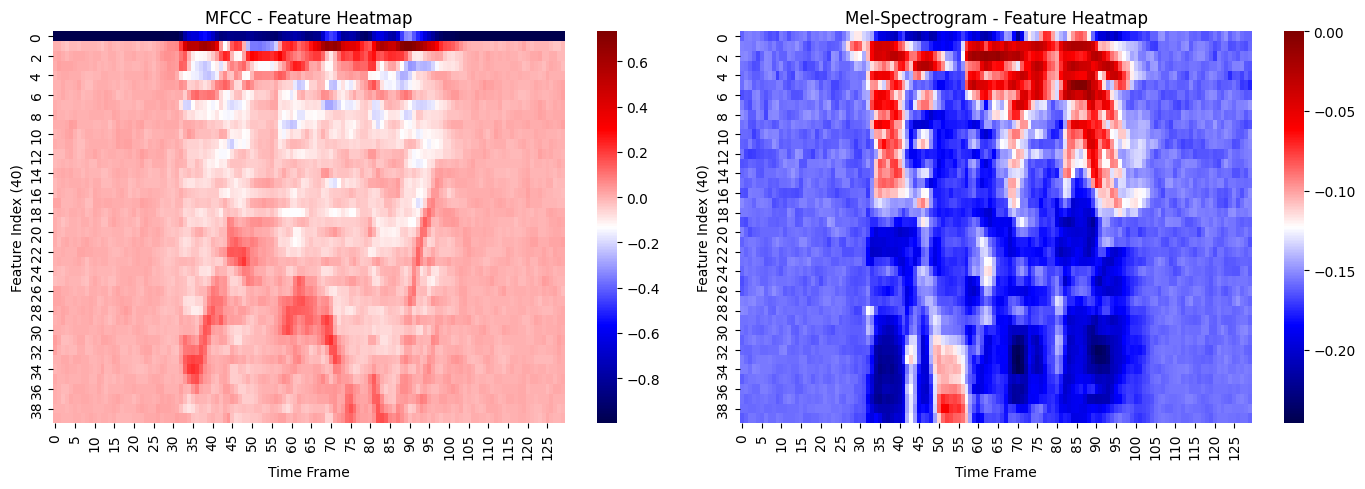

In [28]:
sample_idx = 0
sample = X[sample_idx]  # (2, 130, 40)
methods = ['MFCC', 'Mel-Spectrogram']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i in range(2):
    sns.heatmap(sample[i].T, ax=axes[i], cmap='seismic', cbar=True)
    axes[i].set_title(f"{methods[i]} - Feature Heatmap")
    axes[i].set_xlabel("Time Frame")
    axes[i].set_ylabel("Feature Index (40)")
plt.tight_layout()
plt.show()

## Preprocessing

In [29]:
#Mini-batch class
class mini_batch(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [30]:
#Train/Test/Val split
X_reshape = X[:, np.newaxis, :, :, :]
X_train, X_temp, y_train, y_temp = train_test_split(X_reshape, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [31]:
X_train.shape

(2457, 1, 2, 130, 40)

## Mini-batch

In [32]:
#Create mini-batch
train_loader = DataLoader(mini_batch(X_train, y_train), batch_size=32, shuffle=True)
val_loader   = DataLoader(mini_batch(X_val, y_val), batch_size=32, shuffle=False)
test_loader  = DataLoader(mini_batch(X_test, y_test), batch_size=32, shuffle=False)

In [33]:
for batch_X, batch_y in train_loader:
    print("Batch X shape:", batch_X.shape)
    print("Batch y shape:", batch_y.shape)
    break

Batch X shape: torch.Size([32, 1, 2, 130, 40])
Batch y shape: torch.Size([32])


# Modeling

## Build model

In [34]:
class Conv3D(nn.Module):
    def __init__(
        self,
        num_classes=8,
        conv_channels=[32, 64, 128, 128, 256],
        dropout=0.3,
        fc_dim=128,
        input_shape=(1, 2, 130, 40)  # (C, D, T, F)
    ):
        super().__init__()

        self.conv_layers = nn.Sequential()
        in_channels = input_shape[0]

        for i, out_channels in enumerate(conv_channels):
            self.conv_layers.add_module(f"conv3d_{i}", nn.Conv3d(
                in_channels, out_channels, kernel_size=(3, 3, 3), padding=1
            ))
            self.conv_layers.add_module(f"gn_{i}", nn.GroupNorm(num_groups=4, num_channels=out_channels))
            self.conv_layers.add_module(f"relu_{i}", nn.ReLU())
            self.conv_layers.add_module(f"dropout3d_{i}", nn.Dropout3d(p=0.1))
            self.conv_layers.add_module(f"pool_{i}", nn.MaxPool3d(kernel_size=(1, 2, 2)))  # giảm freq & time
            in_channels = out_channels

        self.global_pool = nn.AdaptiveAvgPool3d((1, 1, 1))

        # Tính dimension sau conv
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            dummy_out = self.global_pool(self.conv_layers(dummy))
            self.flatten_dim = dummy_out.view(1, -1).shape[1]

        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(self.flatten_dim, fc_dim)
        self.fc2 = nn.Linear(fc_dim, num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_pool(x)
        x = x.flatten(1)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)

## Tuning hyperparameter

In [26]:
def build_model(trial):
    conv1 = trial.suggest_categorical("conv1", [16, 32, 64])
    conv2 = trial.suggest_categorical("conv2", [32, 64, 128])
    conv3 = trial.suggest_categorical("conv3", [64, 128])
    conv4 = trial.suggest_categorical("conv4", [128, 256])
    conv5 = trial.suggest_categorical("conv5", [128, 256, 384])

    dropout = trial.suggest_float("dropout", 0.3, 0.5)
    fc_dim = trial.suggest_categorical("fc_dim", [64, 128, 256])

    conv_channels = [conv1, conv2, conv3, conv4, conv5]

    model = Conv3D(
        num_classes=8,
        conv_channels=conv_channels,
        dropout=dropout,
        fc_dim=fc_dim
    )

    return model

In [27]:
def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = build_model(trial).to(device)

    # Hyperparameter
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0
    patience = 5
    counter = 0
    max_epochs = 30

    for epoch in range(max_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            out = model(batch_X)
            loss = criterion(out, batch_y)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                out = model(batch_X)
                preds = out.argmax(dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(batch_y.cpu().numpy())

        val_acc = accuracy_score(all_labels, all_preds)
        trial.report(val_acc, step=epoch)

        # Early stop
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break

    return best_val_acc

In [28]:
study_hyperparam = optuna.create_study(direction="maximize")
study_hyperparam.optimize(objective, n_trials=50)

best_trial = study_hyperparam.best_trial
print(best_trial.number)
print(best_trial.value)
print(best_trial.params)

[I 2025-08-01 19:42:00,928] A new study created in memory with name: no-name-26a010df-6f47-46a8-a963-674ea8c9f44c
[I 2025-08-01 19:42:46,410] Trial 0 finished with value: 0.7296416938110749 and parameters: {'conv1': 32, 'conv2': 32, 'conv3': 64, 'conv4': 128, 'conv5': 256, 'dropout': 0.34179666778925294, 'fc_dim': 64, 'lr': 0.00048636395874931374}. Best is trial 0 with value: 0.7296416938110749.
[I 2025-08-01 19:43:07,025] Trial 1 finished with value: 0.1270358306188925 and parameters: {'conv1': 64, 'conv2': 64, 'conv3': 128, 'conv4': 256, 'conv5': 256, 'dropout': 0.4419290958701158, 'fc_dim': 128, 'lr': 0.0010046838516275687}. Best is trial 0 with value: 0.7296416938110749.
[I 2025-08-01 19:43:55,307] Trial 2 finished with value: 0.6579804560260586 and parameters: {'conv1': 32, 'conv2': 32, 'conv3': 64, 'conv4': 256, 'conv5': 384, 'dropout': 0.45668402410726255, 'fc_dim': 256, 'lr': 0.0008770023893032304}. Best is trial 0 with value: 0.7296416938110749.
[I 2025-08-01 19:44:38,214] Tri

16
0.8697068403908795
{'conv1': 16, 'conv2': 128, 'conv3': 128, 'conv4': 256, 'conv5': 128, 'dropout': 0.302706072464885, 'fc_dim': 256, 'lr': 0.0003336907679588947}


## Training model

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 100

train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

model = Conv3D(
    num_classes=8,
    conv_channels=[16, 128, 128, 256, 128],
    dropout=0.3027,
    fc_dim=128,
    input_shape=(1, 2, 130, 40)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr= 0.00033369)
criterion = nn.CrossEntropyLoss()

best_acc = 0
counter = 0
patience = 5

for epoch in range(num_epochs):
    # ----- TRAIN -----
    model.train()
    train_loss, train_preds, train_labels = 0, [], []
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(output.argmax(dim=1).cpu().numpy())
        train_labels.extend(batch_y.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)
    train_loss /= len(train_loader)

    # ----- VALIDATION -----
    model.eval()
    val_loss, val_preds, val_labels = 0, [], []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            loss = criterion(output, batch_y)
            val_loss += loss.item()
            val_preds.extend(output.argmax(dim=1).cpu().numpy())
            val_labels.extend(batch_y.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    val_loss /= len(val_loader)

    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        best_model = deepcopy(model.state_dict())
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopped at epoch {epoch}")
            break

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    # ----- LOG -----
    print(f"Epoch {epoch+1:02d} | "
          f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        output = model(batch_X)
        preds = output.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch_y.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

Epoch 01 | Train Loss: 2.0980 | Train Accuracy: 0.1270 | Val Loss: 2.0825 | Val Accuracy: 0.1270
Epoch 02 | Train Loss: 2.0907 | Train Accuracy: 0.1254 | Val Loss: 2.0793 | Val Accuracy: 0.1238
Epoch 03 | Train Loss: 2.0376 | Train Accuracy: 0.1640 | Val Loss: 1.9854 | Val Accuracy: 0.2150
Epoch 04 | Train Loss: 1.9682 | Train Accuracy: 0.1998 | Val Loss: 1.9429 | Val Accuracy: 0.2378
Epoch 05 | Train Loss: 1.9299 | Train Accuracy: 0.2295 | Val Loss: 1.8887 | Val Accuracy: 0.2573
Epoch 06 | Train Loss: 1.8869 | Train Accuracy: 0.2678 | Val Loss: 1.8135 | Val Accuracy: 0.3029
Epoch 07 | Train Loss: 1.7470 | Train Accuracy: 0.3264 | Val Loss: 1.6537 | Val Accuracy: 0.3648
Epoch 08 | Train Loss: 1.6608 | Train Accuracy: 0.3565 | Val Loss: 1.5836 | Val Accuracy: 0.4137
Epoch 09 | Train Loss: 1.5860 | Train Accuracy: 0.3919 | Val Loss: 1.4972 | Val Accuracy: 0.4463
Epoch 10 | Train Loss: 1.5251 | Train Accuracy: 0.4082 | Val Loss: 1.4571 | Val Accuracy: 0.4235
Epoch 11 | Train Loss: 1.4271 

## Evaluate

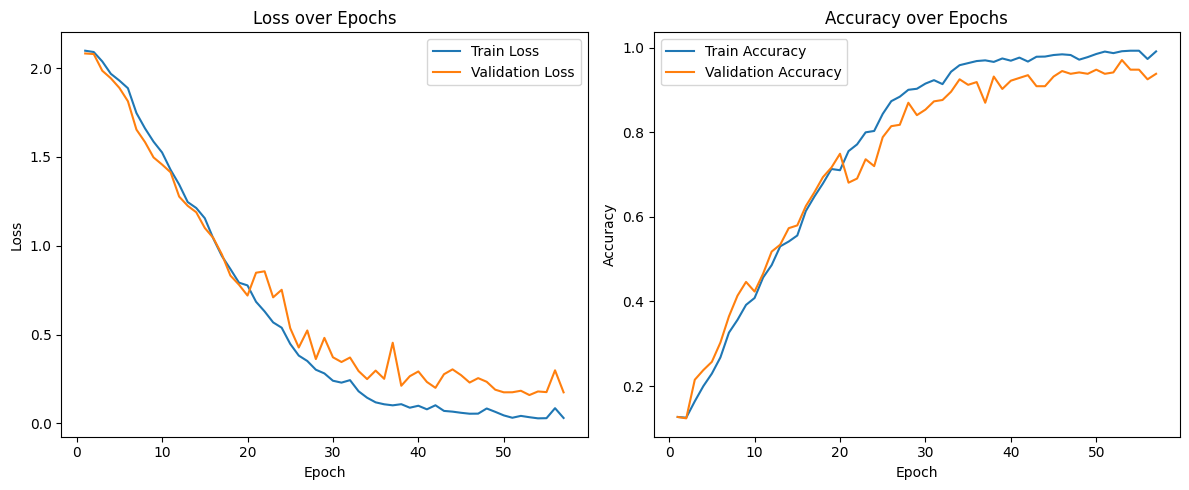

In [40]:
epochs_range = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_list, label='Train Loss')
plt.plot(epochs_range, val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_list, label='Train Accuracy')
plt.plot(epochs_range, val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

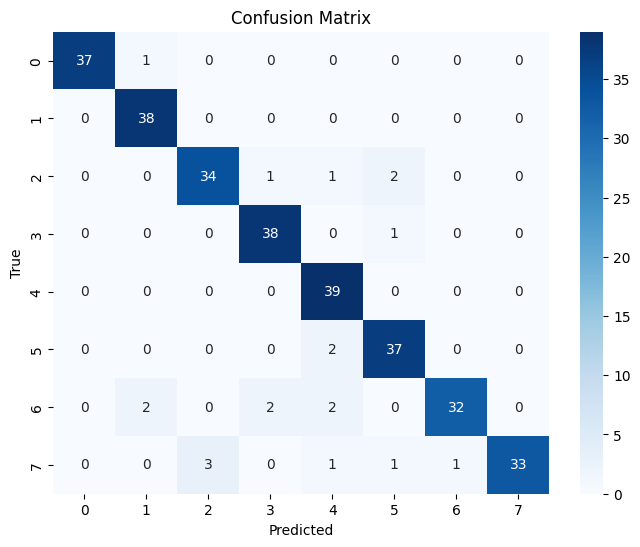

In [41]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(8), yticklabels=range(8))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [42]:
#save model
torch.save(model, "3DCNN_model.pt")